# Example-29: Orbit (fixed point computation)

In [1]:
# In this example computation of fixed points is illustrated
# Fixed points are computed for given initial guess using Newton root search method
# Closed orbit is computed, which is special case of period one stable (elliptic) fixed point corresponding to center manifold
# Also, period five fixed point is computed (restricted to horizontal plane)

In [2]:
# Import

import torch
torch.set_printoptions(linewidth=128)

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['text.usetex'] = True

from twiss import twiss

from ndmap.signature import chop
from ndmap.evaluate import evaluate
from ndmap.pfp import parametric_fixed_point

from ndmap.pfp import clean_point
from ndmap.pfp import chain_point
from ndmap.pfp import matrix

from model.library.drift import Drift
from model.library.quadrupole import Quadrupole
from model.library.sextupole import Sextupole
from model.library.dipole import Dipole
from model.library.line import Line

from model.command.wrapper import group
from model.command.orbit import orbit

In [3]:
# Define simple FODO based lattice using nested lines

DR = Drift('DR', 0.25)
BM = Dipole('BM', 3.50, torch.pi/4.0)

QF_A = Quadrupole('QF_A', 0.5, +0.20)
QD_A = Quadrupole('QD_A', 0.5, -0.19)
QF_B = Quadrupole('QF_B', 0.5, +0.20)
QD_B = Quadrupole('QD_B', 0.5, -0.19)
QF_C = Quadrupole('QF_C', 0.5, +0.20)
QD_C = Quadrupole('QD_C', 0.5, -0.19)
QF_D = Quadrupole('QF_D', 0.5, +0.20)
QD_D = Quadrupole('QD_D', 0.5, -0.19)

SF_A = Sextupole('SF_A', 0.25, 0.00)
SD_A = Sextupole('SD_A', 0.25, 0.00)
SF_B = Sextupole('SF_B', 0.25, 0.00)
SD_B = Sextupole('SD_B', 0.25, 0.00)
SF_C = Sextupole('SF_C', 0.25, 0.00)
SD_C = Sextupole('SD_C', 0.25, 0.00)
SF_D = Sextupole('SF_D', 0.25, 0.00)
SD_D = Sextupole('SD_D', 0.25, 0.00)

FODO_A = Line('FODO_A', [QF_A, DR, SF_A, DR, BM, DR, SD_A, DR, QD_A, QD_A, DR, SD_A, DR, BM, DR, SF_A, DR, QF_A], propagate=True, dp=0.0, exact=False, output=False, matrix=False)
FODO_B = Line('FODO_B', [QF_B, DR, SF_B, DR, BM, DR, SD_B, DR, QD_B, QD_B, DR, SD_B, DR, BM, DR, SF_B, DR, QF_B], propagate=True, dp=0.0, exact=False, output=False, matrix=False)
FODO_C = Line('FODO_C', [QF_C, DR, SF_C, DR, BM, DR, SD_C, DR, QD_C, QD_C, DR, SD_C, DR, BM, DR, SF_C, DR, QF_C], propagate=True, dp=0.0, exact=False, output=False, matrix=False)
FODO_D = Line('FODO_D', [QF_D, DR, SF_D, DR, BM, DR, SD_D, DR, QD_D, QD_D, DR, SD_D, DR, BM, DR, SF_D, DR, QF_D], propagate=True, dp=0.0, exact=False, output=False, matrix=False)

RING = Line('RING', [FODO_A, FODO_B, FODO_C, FODO_D], propagate=True, dp=0.0, exact=False, output=False, matrix=False)

tensor([5.0000, 5.0000], dtype=torch.float64)


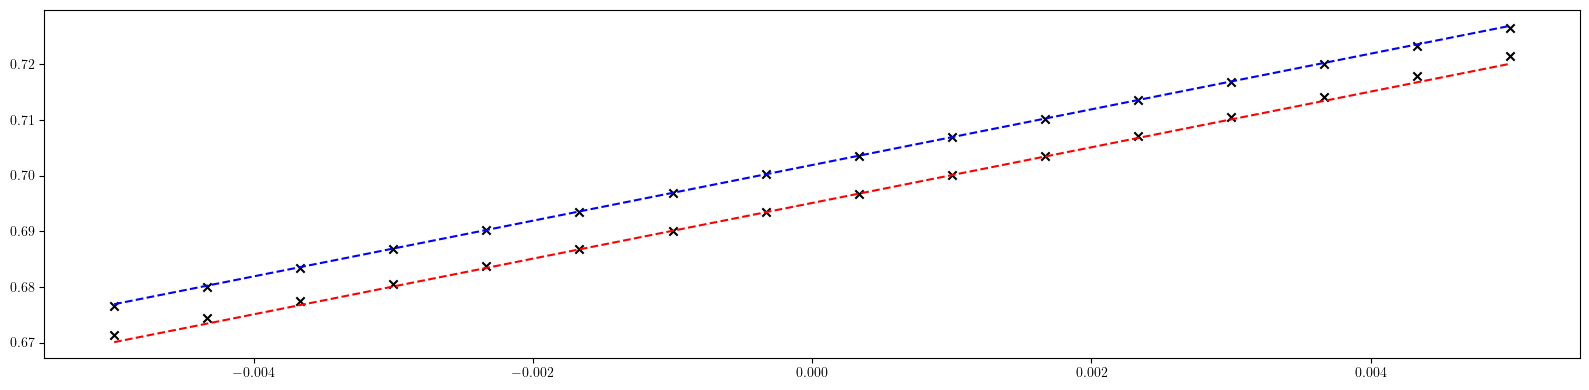

In [4]:
# Correct chromaticity

# Set parametric mapping

ring, *_ = group(RING, 'FODO_A', 'FODO_D', ('ms', ['Sextupole'], None, None), ('dp', None, None, None), root=True, alignment=False)

# Set deviation parameters

fp = torch.tensor(4*[0.0], dtype=torch.float64)
dp = torch.tensor([0.0], dtype=torch.float64)
ms = torch.tensor(8*[0.0], dtype=torch.float64)

# Compute first order parametric fixed point with respect to momentum deviation

pfp, *_ = parametric_fixed_point((0, 1), fp, [ms, dp], ring)
chop(pfp)

# Define ring around fixed point

def mapping(state, ms, dp):
    return ring(state + evaluate(pfp, [ms, dp]), ms, dp) - evaluate(pfp, [ms, dp])

# Tune

def tune(ms, dp):
    matrix = torch.func.jacrev(mapping)(fp, ms, dp)
    tunes, *_ = twiss(matrix)
    return tunes

# Chromaticity

def chromaticity(ms):
    return torch.func.jacrev(tune, 1)(ms, dp)

# Initial chomaticity values

psix, psiy = chromaticity(ms).squeeze()

# Define target chomaticity values

psix_target = torch.tensor(5.0, dtype=torch.float64)
psiy_target = torch.tensor(5.0, dtype=torch.float64)

# Perform correction

dpsix = psix - psix_target
dpsiy = psiy - psiy_target

# Set solution

solution = - torch.linalg.pinv((torch.func.jacrev(chromaticity)(ms)).squeeze()) @ torch.stack([dpsix, dpsiy])

# Set sextupoles
# Note, ring function in not effected

SF_A.ms, SD_A.ms, SF_B.ms, SD_B.ms, SF_C.ms, SD_C.ms, SF_D.ms, SD_D.ms = solution.tolist()

# Check chromaticity

print(chromaticity(solution).squeeze())

# Plot tunes vs momentum deviation

nux, nuy = tune(solution, dp)

dps = torch.linspace(-5.0E-3, 5.0E-3, 16, dtype=torch.float64)
nuxs, nuys = torch.stack([tune(solution, dp) for dp in dps.reshape(-1, 1)]).T

plt.figure(figsize=(16, 4))
plt.plot(dps.cpu().numpy(), (nux + psix_target*dps).cpu().numpy(), color='red', linestyle='dashed')
plt.scatter(dps.cpu().numpy(), nuxs.cpu().numpy(), color='black', marker='x')
plt.plot(dps.cpu().numpy(), (nuy + psiy_target*dps).cpu().numpy(), color='blue', linestyle='dashed')
plt.scatter(dps.cpu().numpy(), nuys.cpu().numpy(), color='black', marker='x')
plt.tight_layout()
plt.show()

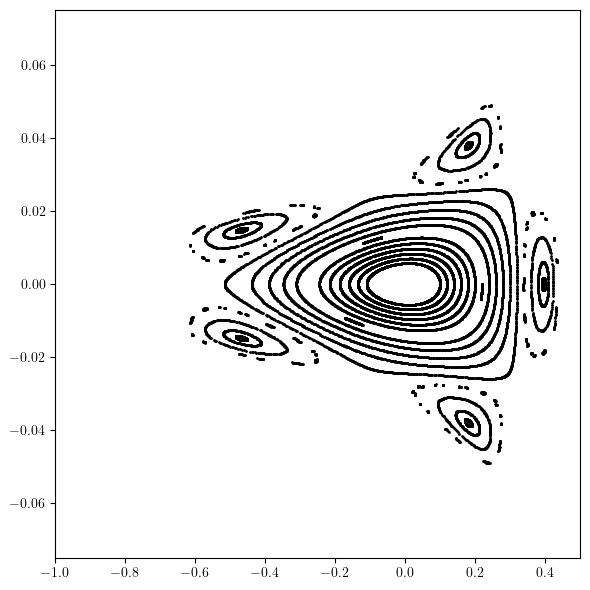

In [5]:
# Generate and plot phase space trajectories

qx = torch.linspace(0.10, 0.4, 16, dtype=torch.float64)
px = torch.zeros_like(qx)
qy = torch.zeros_like(qx)
py = torch.zeros_like(qx)

state = torch.stack([qx, px, qy, py]).T
trjs = []

for _ in range(2**10):
    state = torch.vmap(RING)(state)
    trjs.append(state)

qx, px, *_ = torch.stack(trjs).swapaxes(0, -1)

plt.figure(figsize=(6, 6))
plt.scatter(qx.cpu().numpy(), px.cpu().numpy(), s=1, color='black')
plt.xlim(-1.0, 0.5)
plt.ylim(-0.075, 0.075)
plt.tight_layout()
plt.show()

In [6]:
# Compute closed orbit (period one fixed point)

# Set initial guess

guess = 1.0E-3*torch.tensor([1.0, -1.0, 1.0, -1.0], dtype=torch.float64)

# Compute without deviation parameters and groups

point, table = orbit(RING, guess, [], limit=8, epsilon=1.0E-6)

print(table)
print(point)
print(RING(point))
print()

# Compute matrix around closed orbit

print(torch.func.jacrev(RING)(point))
print()

print(matrix(1, ring, point, ms, dp, jacobian=torch.func.jacrev))
print()

# Classify fixed point

values, _ = torch.linalg.eig(matrix(1, ring, point, ms, dp, jacobian=torch.func.jacrev))
print(values.log().real)
print()

# Deviation parameters are passed after the initial guess, followed by deviation groups

point, table = orbit(RING, guess, [ms, dp], ('ms', ['Sextupole'], None, None), ('dp', None, None, None), limit=8, epsilon=1.0E-6)

print(table)
print(point)
print(RING(point))
print()

# Track closed orbit
# Note, number of points is equal to the number of lines plus one (full=True, default) or number of lines (full=False)

points, table = orbit(RING, guess, [ms, dp], ('ms', ['Sextupole'], None, None), ('dp', None, None, None), advance=True, limit=8, epsilon=1.0E-6)

print(table)
print(points)
print(points.shape)
print(len(RING))
print()

# Closed orbit with non-zero deviation parameters
# Note, alignment flag should be explicitly passed

fp = torch.tensor(4*[0.0], dtype=torch.float64)
dx = torch.tensor([-0.001], dtype=torch.float64)
dy = torch.tensor([+0.001], dtype=torch.float64)
dp = torch.tensor([0.0005], dtype=torch.float64)

ring, *_ = group(RING, 'FODO_A', 'FODO_D', ('dx', None, ['QD_A'], None), ('dy', None, ['QD_A'], None), ('dp', None, None, None), root=True, alignment=True)

print(fp)
print(ring(fp, dx, dy, dp))
print()

point, _ = orbit(RING, guess, [dx, dy, dp], ('dx', None, ['QD_A'], None), ('dy', None, ['QD_A'], None), ('dp', None, None, None), alignment=True, limit=8, epsilon=1.0E-6)

print(point)
print(ring(point, dx, dy, dp))
print()

[]
tensor([ 2.9857e-18, -2.0620e-19, -2.9122e-19, -3.0706e-20], dtype=torch.float64)
tensor([ 2.6010e-18,  2.2073e-19,  2.7221e-19, -3.4789e-20], dtype=torch.float64)

tensor([[-3.3823e-01, -1.7512e+01,  4.0542e-19,  7.6920e-18],
        [ 5.0572e-02, -3.3823e-01, -7.0284e-20,  1.3939e-19],
        [-1.4957e-19, -8.2174e-18, -2.9764e-01, -6.0422e+00],
        [ 6.4815e-20, -4.3138e-19,  1.5084e-01, -2.9764e-01]], dtype=torch.float64)

tensor([[-3.3823e-01, -1.7512e+01, -3.8455e-33, -5.8351e-32],
        [ 5.0572e-02, -3.3823e-01,  4.9958e-34, -5.6691e-34],
        [ 7.8130e-34,  5.7800e-32, -2.9764e-01, -6.0422e+00],
        [-4.8163e-34,  4.4705e-33,  1.5084e-01, -2.9764e-01]], dtype=torch.float64)

tensor([-1.6398e-15, -1.6398e-15, -1.2069e-16, -1.2069e-16], dtype=torch.float64)

[(None, ['SF_A', 'SD_A', 'SF_B', 'SD_B', 'SF_C', 'SD_C', 'SF_D', 'SD_D'], 'ms'), (None, None, 'dp')]
tensor([ 2.9857e-18, -2.0620e-19, -2.9123e-19, -3.0706e-20], dtype=torch.float64)
tensor([ 2.6010e-18,  2.

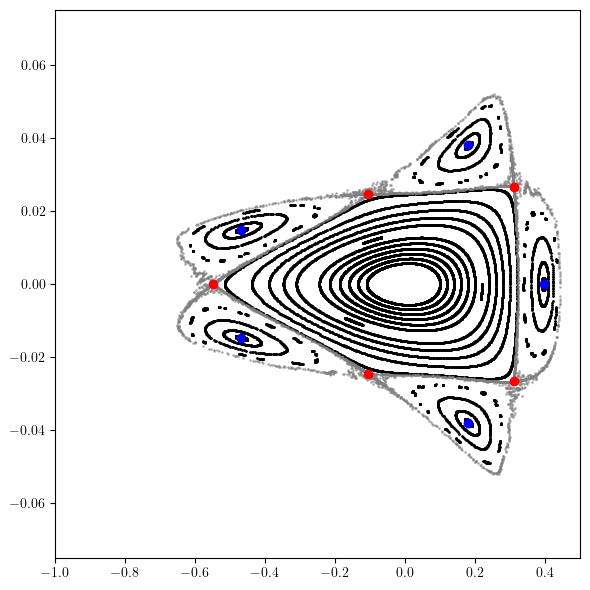

In [7]:
# Locate period five fixed points

dp = torch.tensor([0.0], dtype=torch.float64)
ms = torch.tensor(8*[0.0], dtype=torch.float64)

# Set fixed point period

power = 5

# Set tolerance epsilon

epsilon = 1.0E-9

# Set random initial points

qx = 1.0*torch.rand(256, dtype=torch.float64) - 0.50
px = 0.1*torch.rand(256, dtype=torch.float64) - 0.05
qy = torch.zeros_like(qx)
py = torch.zeros_like(px)

points = torch.stack([qx, px, qy, py]).T

def task(guess):
    point, _ = orbit(RING, 
                     guess, 
                     [ms, dp], 
                     ('ms', ['Sextupole'], None, None), 
                     ('dp', None, None, None), 
                     limit=128, 
                     power=power, 
                     epsilon=None)
    return point

# Perform root search iterations for each initial point

points = torch.func.vmap(task)(points)

# Set parametric ring

ring, *_ = group(RING, 'FODO_A', 'FODO_D', ('ms', ['Sextupole'], None, None), ('dp', None, None, None), root=True, alignment=True)

# Iterate

for _ in range(128):
    locals = torch.vmap(lambda state: ring(state, ms, dp))(points)

# Remove solutions with large norms

points = points[locals.norm(1, dim=-1) < 0.5]

# Remove unconverged solutions

mask = []
for point in points:
    local = point.clone()
    for _ in range(power):
        local = ring(local, ms, dp)
    mask.append((local - point).norm() < epsilon)

points = points[mask]

# Clean points (remove nans, duplicates, points from the same chain)

points = clean_point(power, ring, points, ms, dp, epsilon=epsilon)

# Generate fixed point chains

chains = torch.func.vmap(lambda point: chain_point(power, ring, point, ms, dp))(points)

# Classify fixed point chains (elliptic vs hyperbolic)
# Generate initials for hyperbolic fixed points using corresponding eigenvectors

kinds = []
for chain in chains:
    point, *_ = chain
    values, vectors = torch.linalg.eig(matrix(power, ring, point, ms, dp))
    kind = values.log().real.prod() < epsilon
    kinds.append(bool(kind))
    if not kind:
        lines = [point + vector*torch.linspace(-epsilon, +epsilon, 128, dtype=torch.float64).reshape(-1, 1) for vector in vectors.real.T]
        lines = torch.stack(lines).reshape(-1, 4)

# Remove vertical plane in chains

qx, px, *_ = chains.swapaxes(0, -1)
chains = torch.stack([qx, px]).swapaxes(0, -1)

# Iterate lines and remove vertical plane

manifold = []
for _ in range(64):
    manifold.append(lines)
    lines = torch.func.vmap(lambda point: ring(point, ms, dp))(lines)
manifold = torch.stack(manifold)

# Remove vertical plane in lines (including nonlinear leaking)

qx, px, qy, py = manifold.swapaxes(0, -1)
qx = qx[qy.abs() + py.abs() < epsilon]
px = px[qy.abs() + py.abs() < epsilon]
manifold = torch.stack([qx, px])

# Plot 

plt.figure(figsize=(6, 6))
qx, px, *_ = torch.stack(trjs).swapaxes(0, -1)
plt.scatter(qx.cpu().numpy(), px.cpu().numpy(), s=1, color='black')
qx, px = manifold
plt.scatter(qx.flatten().cpu().numpy(), px.flatten().cpu().numpy(), s=1, color='grey', alpha=0.5)
for chain, kind in zip(chains, kinds):
    plt.scatter(*chain.T, color = {True:'blue', False:'red'}[kind], marker='o')
plt.xlim(-1.0, 0.5)
plt.ylim(-0.075, 0.075)
plt.tight_layout()
plt.show()